In [30]:
!rm -r datasets/onlyact

In [31]:
!mkdir datasets/onlyact
!mkdir datasets/onlyact/train
!mkdir datasets/onlyact/val
#!mkdir datasets/onlyact/test
!mkdir datasets/onlyact/train/images
!mkdir datasets/onlyact/train/labels
!mkdir datasets/onlyact/val/images
!mkdir datasets/onlyact/val/labels
#!mkdir datasets/onlyact/test/images
#!mkdir datasets/onlyact/test/labels

In [2]:
import numpy as np, pandas as pd, astropy.table as atpy, astropy.coordinates as coord, astropy.units as u
from pixell import enmap, enplot, reproject
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import convert_functions as covF
path = '../'
import astropy

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from tqdm import tqdm
import torch
from torch.nn.functional import normalize
tqdm.pandas()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
imap90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits')[0]
imap150 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map.fits')[0]
imap220 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_map.fits')[0]

In [4]:
# Point sourcers
d56 = atpy.Table().read(path + 'ACTPol-D56_sources.fits').to_pandas().reset_index(drop=True)
d6 = atpy.Table().read(path + 'ACTPol-D6_sources.fits').to_pandas().reset_index(drop=True)
d5 = atpy.Table().read(path + 'ACTPol-D5_sources.fits').to_pandas().reset_index(drop=True)
g1 = atpy.Table().read(path + 'act_equatorial_galactic_gralla_v1.txt', format='ascii.fixed_width').to_pandas().reset_index(drop=True)
g11 = atpy.Table().read(path + 'act_equatorial_extragalactic_gralla_v1_1.txt', format='ascii.fixed_width').to_pandas().reset_index(drop=True)
s1 = atpy.Table().read(path + 'act_southern_sources_v1_0.fits', format='fits').to_pandas().reset_index(drop=True)

point = pd.concat([d56[['RA [deg]', 'dec [deg]']].rename(columns={'RA [deg]': 'ra', 'dec [deg]': 'dec'}),
                   d6[['RA [deg]', 'dec [deg]']].rename(columns={'RA [deg]': 'ra', 'dec [deg]': 'dec'}), 
                   d5[['RA [deg]', 'dec [deg]']].rename(columns={'RA [deg]': 'ra', 'dec [deg]': 'dec'}), 
                   g1[['ra', 'dec']], 
                   g11[['ra', 'dec']], 
                  s1[['ra', 'dec']]]).reset_index(drop=True)
point.rename(columns={'ra':'RADeg', 'dec': 'decDeg'}, inplace=True)
len(point)

2761

In [5]:
dr5 = atpy.Table().read(path + 'DR5_cluster-catalog_v1.1.fits').to_pandas().reset_index(drop=True)

In [6]:
row = dr5[dr5.M500c > 10].sample(1, random_state=48).reset_index(drop=True).iloc[0]
size=200
width = size*0.5/60
r = 8.*np.pi/(60 * 180)

box = np.deg2rad([[row.decDeg-width/2.,row.RADeg-width/2.],[row.decDeg+width/2.,row.RADeg+width/2.]])
pixbox = np.array([[0, 0,], [size, size]])

data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
data150 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map.fits', box=box, pixbox=pixbox)[0]
data220 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_map.fits', box=box, pixbox=pixbox)[0]

#data90 = reproject.thumbnails(imap90, coords = np.deg2rad([row.decDeg, row.RADeg]), res = 0.0000454440 , r = r)
#data150 = reproject.thumbnails(imap150, coords = np.deg2rad([row.decDeg, row.RADeg]), res =  0.0000454440, r = r)
#data220 = reproject.thumbnails(imap220, coords = np.deg2rad([row.decDeg, row.RADeg]), res =  0.0000454440, r = r)

M = np.round(dr5['M500c'][0], 2)
z = np.round(dr5['redshift'][0], 2)
if np.isnan(M):
    label = 0
else:
    label = 1

img = np.stack([data90, data150, data220], axis=-1)

In [7]:
row['M500c']

11.002139512500548

In [8]:
if label == 1:
    theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500) #arcmin
else:
    theta = 10 #arcmin
        
theta = theta*0.5
img_height = img.shape[0]
img_width = img.shape[1]
x_centre, y_centre = int(img_height/2), int(img_width/2)
norm_xc = x_centre/img_width
norm_yc = y_centre/img_height
norm_width = theta/img_width
norm_height = theta/img_height

yolo_annotations = ['0', ' ' + str(norm_xc), 
                    ' ' + str(norm_yc), 
                    ' ' + str(norm_width), 
                    ' ' + str(norm_height), '\n']

#f.writelines(yolo_annotations)

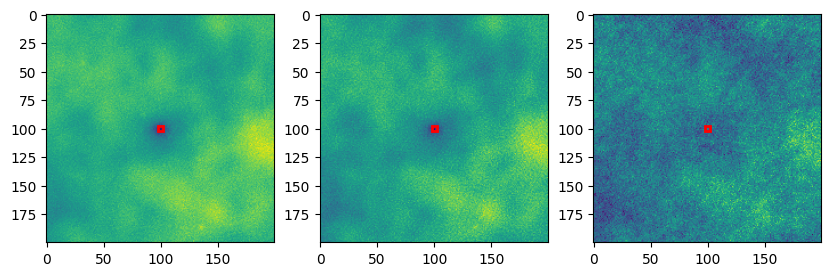

In [9]:
# Рассчитываем координаты верхнего левого угла
top_left_x = x_centre - (theta / 2)
top_left_y = y_centre - (theta / 2)
fig, ax = plt.subplots(figsize=(10, 5), ncols=3)
ax[0].imshow(img[:, :, 0])
ax[1].imshow(img[:, :, 1])
ax[2].imshow(img[:, :, 2])
# Добавляем bounding box
rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)
rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)
plt.show()

In [10]:
inbox = dr5[(dr5.decDeg > (row.decDeg-width/2.)) & (dr5.decDeg < (row.decDeg+width/2.)) & (dr5.RADeg < (row.RADeg+width/2.)) & (dr5.RADeg > (row.RADeg-width/2.))]
inbox

,name,RADeg,decDeg,SNR,y_c,err_y_c,fixed_SNR,fixed_y_c,fixed_err_y_c,template,...,RMDESY3_LAMBDA_CHISQ_E,CAMIRA,CAMIRA_N_mem,opt_RADeg,opt_decDeg,opt_positionSource,notes,knownLens,knownLensRefCode,warnings
3323,b'ACT-CL J1632.7+0534',248.196618,5.577581,35.121321,2.93768,0.083644,34.432096,3.803601,0.110467,b'Arnaud_M8e14_z0p4',...,-99.0,False,-99.0,248.194232,5.575112,b'Vis-BCG',NaN,NaN,NaN,NaN


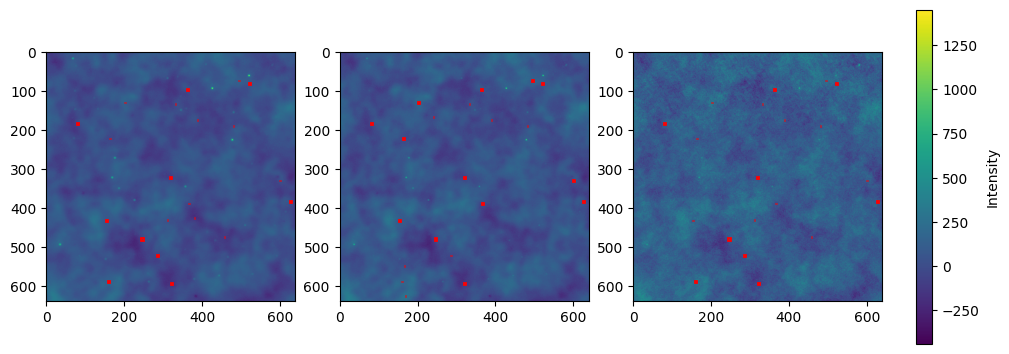

In [40]:
row = dr5.sample(1, random_state=4).reset_index(drop=True).iloc[0]
size=640
width = size*0.5/60
r = 8.*np.pi/(60 * 180)

box = np.deg2rad([[row.decDeg-width/2.,row.RADeg-width/2.],[row.decDeg+width/2.,row.RADeg+width/2.]])
pixbox = np.array([[0, 0,], [size, size]])

data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
data150 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map.fits', box=box, pixbox=pixbox)[0]
data220 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_map.fits', box=box, pixbox=pixbox)[0]

M = np.round(row['M500c'], 2)
z = np.round(row['redshift'], 2)
if np.isnan(M):
    label = 0
else:
    label = 1

img = np.stack([data90, data150, data220], axis=-1)

if label == 1:
    theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500) #arcmin
else:
    theta = 2 #arcmin
        
img = np.stack([data90, data150, data220], axis=-1)
vmin = img.min()
vmax = img.max()
fig, ax = plt.subplots(figsize=(10, 5), ncols=3, constrained_layout=True)
ax[0].imshow(img[:, :, 0], vmin = vmin, vmax = vmax)
ax[1].imshow(img[:, :, 1], vmin = vmin, vmax = vmax)
im = ax[2].imshow(img[:, :, 2], vmin = vmin, vmax = vmax)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Intensity')

incl = dr5[(dr5.decDeg > (row.decDeg-width/2.)) & (dr5.decDeg < (row.decDeg+width/2.)) & (dr5.RADeg < (row.RADeg+width/2.)) & (dr5.RADeg > (row.RADeg-width/2.))]
inp = point[(point.decDeg > (row.decDeg-width/2.)) & (point.decDeg < (row.decDeg+width/2.)) & (point.RADeg < (row.RADeg+width/2.)) & (point.RADeg > (row.RADeg-width/2.))]

inbox = pd.concat([incl, inp]).reset_index(drop=True)
data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
for i in range(len(inbox)):
    #print(inbox['M500c'][i])
    if np.isnan(inbox['M500c'][i]):
        label = 0
        theta = 10
        M = 0
        z = 0
        color='orange'
    else:
        label = 1
        M = np.round(inbox['M500c'][i], 2)
        z = np.round(inbox['redshift'][i], 2)
        theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500)
        color='red'
    #lables  
    theta = theta*0.5 #pixels theta = width , height

    theta = theta*0.5
    img_height, img_width = size, size
    x_centre, y_centre = data90.sky2pix([np.deg2rad(inbox['decDeg'][i]), np.deg2rad(inbox['RADeg'][i])])
    #x_centre, y_centre = int(img_height), int(img_width)
    norm_xc = x_centre/img_width
    norm_yc = y_centre/img_height
    norm_width = theta/img_width
    norm_height = theta/img_height
    
    # Рассчитываем координаты верхнего левого угла
    top_left_x = x_centre - (theta / 2)
    top_left_y = y_centre - (theta / 2)
    
    rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                         linewidth=2, edgecolor=color, facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                             linewidth=2, edgecolor=color, facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                             linewidth=2, edgecolor=color, facecolor='none')
    ax[2].add_patch(rect)
plt.show()

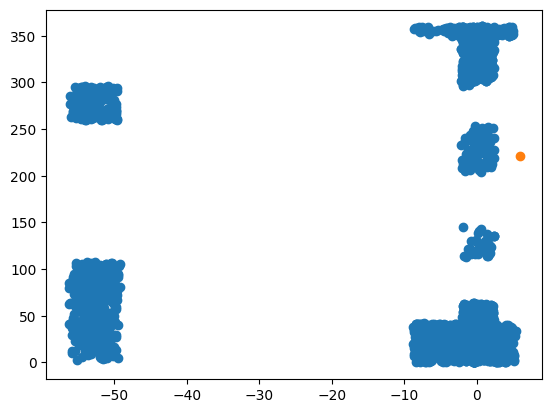

In [39]:
plt.scatter(point.decDeg, point.RADeg)
plt.scatter(5.9, 221.3)

In [37]:
row

name                      b'ACT-CL J1445.3+0554'
RADeg                                 221.335211
decDeg                                   5.91322
SNR                                     4.853091
y_c                                     0.362211
err_y_c                                 0.074635
fixed_SNR                               4.846904
fixed_y_c                               0.442926
fixed_err_y_c                           0.091383
template                    b'Arnaud_M1e14_z0p2'
tileName                                b'2_1_4'
redshift                                0.204938
redshiftErr                                  0.0
redshiftType                             b'spec'
redshiftSource                     b'PublicSpec'
M500c                                   1.555726
M500c_errPlus                           0.411718
M500c_errMinus                           0.32556
M500cCal                                2.191164
M500cCal_errPlus                        0.618817
M500cCal_errMinus   

(640, 640)
(640, 640)


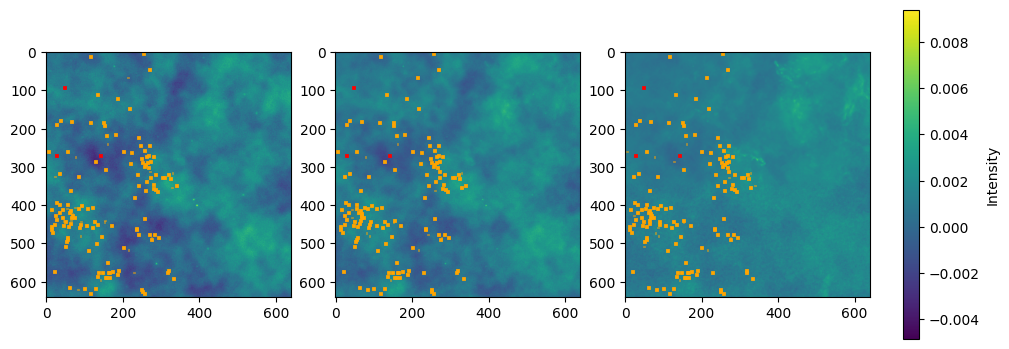

In [43]:
row = point.sample(1, random_state=4).reset_index(drop=True).iloc[0]
size=640
width = size*0.5/60
r = 8.*np.pi/(60 * 180)

box = np.deg2rad([[row.decDeg-width/2.,row.RADeg-width/2.],[row.decDeg+width/2.,row.RADeg+width/2.]])
pixbox = np.array([[0, 0,], [size, size]])

data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
data150 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map.fits', box=box, pixbox=pixbox)[0]
data220 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_map.fits', box=box, pixbox=pixbox)[0]

print(data90.shape)
data90 = np.array(normalize(torch.tensor(np.array(data90).reshape(1, size*size))).view(size, size))
print(data90.shape)
data150 = normalize(torch.tensor(np.array(data150).reshape(1, size*size))).view(size, size)
data220 = normalize(torch.tensor(np.array(data220).reshape(1, size*size))).view(size, size)

#data90 = reproject.thumbnails(imap90, coords = np.deg2rad([row.decDeg, row.RADeg]), res = 0.0000454440 , r = r)
#data150 = reproject.thumbnails(imap150, coords = np.deg2rad([row.decDeg, row.RADeg]), res =  0.0000454440, r = r)
#data220=reproject.thumbnails(imap220, coords = np.deg2rad([row.decDeg, row.RADeg]), res =  0.0000454440, r = r)

M = np.nan #np.round(row['M500c'][0], 2)
z = np.nan #np.round(row['redshift'][0], 2)
if np.isnan(M):
    label = 0
else:
    label = 1

img = np.stack([data90, data150, data220], axis=-1)
vmin = img.min()
vmax = img.max()
fig, ax = plt.subplots(figsize=(10, 5), ncols=3, constrained_layout=True)
ax[0].imshow(img[:, :, 0], vmin = vmin, vmax = vmax)
ax[1].imshow(img[:, :, 1], vmin = vmin, vmax = vmax)
im = ax[2].imshow(img[:, :, 2], vmin = vmin, vmax = vmax)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Intensity')

incl = dr5[(dr5.decDeg > (row.decDeg-width/2.)) & (dr5.decDeg < (row.decDeg+width/2.)) & (dr5.RADeg < (row.RADeg+width/2.)) & (dr5.RADeg > (row.RADeg-width/2.))]
inp = point[(point.decDeg > (row.decDeg-width/2.)) & (point.decDeg < (row.decDeg+width/2.)) & (point.RADeg < (row.RADeg+width/2.)) & (point.RADeg > (row.RADeg-width/2.))]

inbox = pd.concat([incl, inp]).reset_index(drop=True)
data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
for i in range(len(inbox)):
    #print(inbox['M500c'][i])
    if np.isnan(inbox['M500c'][i]):
        label = 0
        theta = 10
        M = 0
        z = 0
        color='orange'
    else:
        label = 1
        M = np.round(inbox['M500c'][i], 2)
        z = np.round(inbox['redshift'][i], 2)
        theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500)
        color='red'
    #lables  
    theta = theta*0.5 #pixels theta = width , height

    theta = theta*0.5
    img_height, img_width = size, size
    x_centre, y_centre = data90.sky2pix([np.deg2rad(inbox['decDeg'][i]), np.deg2rad(inbox['RADeg'][i])])
    #x_centre, y_centre = int(img_height), int(img_width)
    norm_xc = x_centre/img_width
    norm_yc = y_centre/img_height
    norm_width = theta/img_width
    norm_height = theta/img_height
    
    # Рассчитываем координаты верхнего левого угла
    top_left_x = x_centre - (theta / 2)
    top_left_y = y_centre - (theta / 2)
    
    rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                         linewidth=2, edgecolor=color, facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                             linewidth=2, edgecolor=color, facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((top_left_x, top_left_y), theta, theta, 
                             linewidth=2, edgecolor=color, facecolor='none')
    ax[2].add_patch(rect)
plt.show()

In [18]:
data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
data90.sky2pix([inbox['decDeg'][0], inbox['RADeg'][0]])

array([ 9828.98671973, -3410.46934181])

In [25]:
data90.sky2pix([np.deg2rad(inbox['decDeg'][0]), np.deg2rad(inbox['RADeg'][0])])

array([1.5676, 0.784 ])

In [28]:
data90.sky2pix([np.deg2rad(row['decDeg']), np.deg2rad(row['RADeg'])])

array([64.0276, 63.712 ])

In [32]:
len(inbox)

24

In [19]:
data90.corners()

array([[0.02508911, 0.99549217],
       [0.04370595, 1.01410902]])

In [50]:
dr5['label'] = 1
point['label'] = 0

point['M500c'] = np.nan
point['redshift'] = np.nan

data = pd.concat([dr5, point]).reset_index(drop=True)

In [51]:
def create_yolodata(row, size = 32, folder='datasets/onlyact/', imap90=imap90, imap150=imap150, imap220=imap220, dr5=dr5, point=point):
    #images
    r = 8.*np.pi/(60 * 180)
    width = size*0.5/60

    box = np.deg2rad([[row.decDeg-width/2.,row.RADeg-width/2.],[row.decDeg+width/2.,row.RADeg+width/2.]])
    pixbox = np.array([[0, 0,], [size, size]])
    
    data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
    data150 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map.fits', box=box, pixbox=pixbox)[0]
    data220 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_map.fits', box=box, pixbox=pixbox)[0]
    
    data90 = normalize(torch.tensor(np.array(data90).reshape(1, size*size))).view(size, size)
    data150 = normalize(torch.tensor(np.array(data150).reshape(1, size*size))).view(size, size)
    data220 = normalize(torch.tensor(np.array(data220).reshape(1, size*size))).view(size, size)
    
    if np.isnan(row['M500c']):
            label = 0
            theta = 10
            M = 0
            z = 0
    else:
        label = 1
        M = np.round(row['M500c'], 2)
        z = np.round(row['redshift'], 2)
        theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500) #arcmin

    img = np.stack([data90, data150, data220], axis=-1)
    np.save(folder + f"images/ra={np.round(row.RADeg, 2):.2f}_de={np.round(row.decDeg, 2):.2f}_M={M:.2f}_z={z:.2f}_{label}.npy", img)
    
    incl = dr5[(dr5.decDeg > (row.decDeg-width/2.)) & (dr5.decDeg < (row.decDeg+width/2.)) & (dr5.RADeg < (row.RADeg+width/2.)) & (dr5.RADeg > (row.RADeg-width/2.))]
    inp = point[(point.decDeg > (row.decDeg-width/2.)) & (point.decDeg < (row.decDeg+width/2.)) & (point.RADeg < (row.RADeg+width/2.)) & (point.RADeg > (row.RADeg-width/2.))]
    
    inbox = pd.concat([incl, inp]).reset_index(drop=True)

    data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
    for i in range(len(inbox)):
        if np.isnan(inbox['M500c'][i]):
            label = 0
            theta = 10
            M = 0
            z = 0
        else:
            label = 1
            M = np.round(inbox['M500c'][i], 2)
            z = np.round(inbox['redshift'][i], 2)
            theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500)
        #lables  
        theta = theta*0.5 #pixels theta = width , height

        theta = theta*0.5
        img_height, img_width = size, size
        x_centre, y_centre = data90.sky2pix([np.deg2rad(inbox['decDeg'][i]), np.deg2rad(inbox['RADeg'][i])])
        norm_xc = x_centre/img_width
        norm_yc = y_centre/img_height
        norm_width = theta/img_width
        norm_height = theta/img_height

        yolo_annotations = [str(int(label)), ' ' + str(norm_xc), 
                            ' ' + str(norm_yc), 
                            ' ' + str(norm_width), 
                            ' ' + str(norm_height), '\n']
        with open(folder + f"labels/ra={np.round(row.RADeg, 2):.2f}_de={np.round(row.decDeg, 2):.2f}_M={M:.2f}_z={z:.2f}_{label}.txt", 'w') as f:
            f.writelines(yolo_annotations)

In [52]:
def create_yolodata_nonorm(row, size = 32, folder='datasets/onlyact/', imap90=imap90, imap150=imap150, imap220=imap220, dr5=dr5, point=point):
    #images
    r = 8.*np.pi/(60 * 180)
    width = size*0.5/60

    box = np.deg2rad([[row.decDeg-width/2.,row.RADeg-width/2.],[row.decDeg+width/2.,row.RADeg+width/2.]])
    pixbox = np.array([[0, 0,], [size, size]])
    
    data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
    data150 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map.fits', box=box, pixbox=pixbox)[0]
    data220 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_map.fits', box=box, pixbox=pixbox)[0]
    
    #data90 = reproject.thumbnails(imap90, coords = np.deg2rad([row.decDeg, row.RADeg]), res = 0.0000454440 , r = r)
    #data150 = reproject.thumbnails(imap150, coords = np.deg2rad([row.decDeg, row.RADeg]), res =  0.0000454440, r = r)
    #data220=reproject.thumbnails(imap220, coords = np.deg2rad([row.decDeg, row.RADeg]), res =  0.0000454440, r = r)
    
    if np.isnan(row['M500c']):
            label = 0
            theta = 10
            M = 0
            z = 0
    else:
        label = 1
        M = np.round(row['M500c'], 2)
        z = np.round(row['redshift'], 2)
        theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500) #arcmin

    img = np.stack([data90, data150, data220], axis=-1)
    np.save(folder + f"images/ra={np.round(row.RADeg, 2):.2f}_de={np.round(row.decDeg, 2):.2f}_M={M:.2f}_z={z:.2f}_{label}.npy", img)
    
    incl = dr5[(dr5.decDeg > (row.decDeg-width/2.)) & (dr5.decDeg < (row.decDeg+width/2.)) & (dr5.RADeg < (row.RADeg+width/2.)) & (dr5.RADeg > (row.RADeg-width/2.))]
    inp = point[(point.decDeg > (row.decDeg-width/2.)) & (point.decDeg < (row.decDeg+width/2.)) & (point.RADeg < (row.RADeg+width/2.)) & (point.RADeg > (row.RADeg-width/2.))]
    
    inbox = pd.concat([incl, inp]).reset_index(drop=True)

    data90 = enmap.read_map(path + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map.fits', box=box, pixbox=pixbox)[0]
    for i in range(len(inbox)):
        if np.isnan(inbox['M500c'][i]):
            label = 0
            theta = 10
            M = 0
            z = 0
        else:
            label = 1
            M = np.round(inbox['M500c'][i], 2)
            z = np.round(inbox['redshift'][i], 2)
            theta = 3*covF.calcTheta500Arcmin(z, M*1e14, delta=500)
        #lables  
        theta = theta*0.5 #pixels theta = width , height

        theta = theta*0.5
        img_height, img_width = size, size
        x_centre, y_centre = data90.sky2pix([np.deg2rad(inbox['decDeg'][i]), np.deg2rad(inbox['RADeg'][i])])
        norm_xc = x_centre/img_width
        norm_yc = y_centre/img_height
        norm_width = theta/img_width
        norm_height = theta/img_height

        yolo_annotations = [str(int(label)), ' ' + str(norm_xc), 
                            ' ' + str(norm_yc), 
                            ' ' + str(norm_width), 
                            ' ' + str(norm_height), '\n']
        with open(folder + f"labels/ra={np.round(row.RADeg, 2):.2f}_de={np.round(row.decDeg, 2):.2f}_M={M:.2f}_z={z:.2f}_{label}.txt", 'w') as f:
            f.writelines(yolo_annotations)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(data[['RADeg', 'decDeg', 'M500c', 'redshift']], data['label'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
#test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

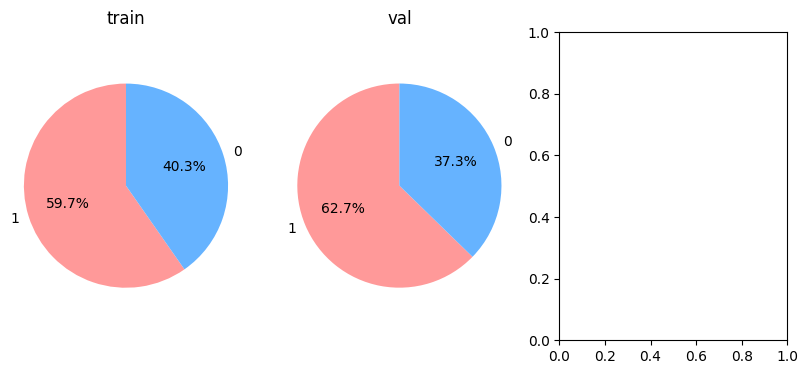

In [54]:
# Построение круговой диаграммы
names = ['train', 'val']#, 'test']
k = 0
fig, ax = plt.subplots(figsize=(10, 4), ncols = 3)
for df in [train, val]:#, test]:
    # Подсчет уникальных значений в 'target'
    target_counts = df['label'].value_counts()

    ax[k].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])

    # Устанавливаем, чтобы оси были равными (чтобы круг не был эллипсом)
    ax[k].axis('equal')

    ax[k].set_title(names[k])
    k+=1
plt.show()

In [ ]:
train.apply(create_yolodata, axis=1, folder='datasets/onlyact/train/')
val.apply(create_yolodata, axis=1, folder='datasets/onlyact/val/')
#test.apply(create_yolodata, axis=1, folder='datasets/onlyact/test/')

In [ ]:
import yaml

# Определяем данные для конфигурационного файла
config = {
    'train': './onlyact/train/images',        # Путь к тренировочным изображениям
    'val': './onlyact/val/images',            # Путь к валидационным изображениям
    #'test': 'datasets/onlyact/test/images',          # Путь к тестовым изображениям (опционально)
    #'nc': 3,                                 # Количество классов
    'names': {0: 'point', 1: 'cluster'}  # Имена классов
}

# Сохраняем конфигурацию в YAML файл
with open('onlyact.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

print("YAML файл создан: onlyact.yaml")

In [49]:
print('a')

a


In [50]:
!rm -r datasets/onlyact128

In [51]:
!mkdir datasets/onlyact128
!mkdir datasets/onlyact128/train
!mkdir datasets/onlyact128/val
#!mkdir datasets/onlyact/test
!mkdir datasets/onlyact128/train/images
!mkdir datasets/onlyact128/train/labels
!mkdir datasets/onlyact128/val/images
!mkdir datasets/onlyact128/val/labels

In [52]:
kwargs = {'size': 128,'folder':'datasets/onlyact128/train/'}
train.apply(create_yolodata, axis=1, **kwargs)
kwargs = {'size': 128, 'folder':'datasets/onlyact128/val/'}
val.apply(create_yolodata, axis=1, **kwargs)

0       None
1       None
2       None
3       None
4       None
        ... 
1387    None
1388    None
1389    None
1390    None
1391    None
Length: 1392, dtype: object

In [69]:
# Определяем данные для конфигурационного файла
config = {
    'train': './onlyact128/train/images',        # Путь к тренировочным изображениям
    'val': './onlyact128/val/images',            # Путь к валидационным изображениям
    #'test': 'datasets/onlyact/test/images',          # Путь к тестовым изображениям (опционально)
    #'nc': 2,                                 # Количество классов
    'names': {0: 'point', 1: 'cluster'}   # Имена классов
}

# Сохраняем конфигурацию в YAML файл
with open('onlyact128.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

print("YAML файл создан: onlyact128.yaml")

YAML файл создан: onlyact128.yaml


In [54]:
!rm -r datasets/onlyact512

rm: cannot remove 'datasets/onlyact512': No such file or directory


In [46]:
!mkdir datasets/onlyact640
!mkdir datasets/onlyact640/train
!mkdir datasets/onlyact640/val
#!mkdir datasets/onlyact/test
!mkdir datasets/onlyact640/train/images
!mkdir datasets/onlyact640/train/labels
!mkdir datasets/onlyact640/val/images
!mkdir datasets/onlyact640/val/labels

In [57]:
kwargs = {'size': 640,'folder':'datasets/onlyact640/train/'}
train.apply(create_yolodata, axis=1, **kwargs)
kwargs = {'size': 640, 'folder':'datasets/onlyact640/val/'}
val.apply(create_yolodata, axis=1, **kwargs)

0       None
1       None
2       None
3       None
4       None
        ... 
1387    None
1388    None
1389    None
1390    None
1391    None
Length: 1392, dtype: object

In [58]:
# Определяем данные для конфигурационного файла
config = {
    'train': './onlyact640/train/images',        # Путь к тренировочным изображениям
    'val': './onlyact640/val/images',            # Путь к валидационным изображениям
    #'test': 'datasets/onlyact/test/images',          # Путь к тестовым изображениям (опционально)
    #'nc': 2,                                 # Количество классов
    'names': {0: 'point', 1: 'cluster'}   # Имена классов
}

# Сохраняем конфигурацию в YAML файл
with open('onlyact640.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

print("YAML файл создан: onlyact512.yaml")

YAML файл создан: onlyact512.yaml


In [61]:
!mkdir datasets/onlyactn
!mkdir datasets/onlyactn/train
!mkdir datasets/onlyactn/val
#!mkdir datasets/onlyact/test
!mkdir datasets/onlyactn/train/images
!mkdir datasets/onlyactn/train/labels
!mkdir datasets/onlyactn/val/images
!mkdir datasets/onlyactn/val/labels

In [65]:
train.apply(create_yolodata_nonorm, axis=1, folder='datasets/onlyactn/train/')
val.apply(create_yolodata_nonorm, axis=1, folder='datasets/onlyactn/val/')

0       None
1       None
2       None
3       None
4       None
        ... 
1387    None
1388    None
1389    None
1390    None
1391    None
Length: 1392, dtype: object

In [71]:
# Определяем данные для конфигурационного файла
config = {
    'train': './onlyactn/train/images',        # Путь к тренировочным изображениям
    'val': './onlyactn/val/images',            # Путь к валидационным изображениям
    #'test': 'datasets/onlyact/test/images',          # Путь к тестовым изображениям (опционально)
    #'nc': 2,                                 # Количество классов
    'names': {0: 'point', 1: 'cluster'}   # Имена классов
}

# Сохраняем конфигурацию в YAML файл
with open('onlyactn.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

print("YAML файл создан: onlyact512.yaml")

YAML файл создан: onlyact512.yaml


In [59]:
print('a')

a
